In [ ]:
# TODO
* It is suprising that there are mostly 3 levels only
* Think about the fact that interactions are typically defined as "the effect of X+Y is different from the effect of X + the effect of Y"
* Identify "2-way-only" interactions (which profile do they have, theoretically? how often do they appear in the data?)
* Identify conditional interactions

### Imports

In [1]:
import statsmodels.api as sm
import statsmodels
import sys
import numpy as np
import scipy.stats as st
import scipy.misc as sp
from sklearn import cluster, metrics

import util_3way # custom functions

%matplotlib inline
import matplotlib.pyplot as plt

### Loading the data

In [2]:
data_fname = 'data/data_DE.txt'
# figure out number of columns 
with open(data_fname, 'r') as f:
    ncols = len(f.readline().split()) + 1 # header row has first column empty, R format
    f.close()
print ncols, "columns"
X = np.loadtxt(data_fname, skiprows=1, usecols=range(1,ncols))
print X.shape

with open(data_fname, 'r') as f:
    f.readline() # header
    gene_names = [line.split()[0] for line in f]
    f.close()

52 columns
(3923, 51)


## Looking at the data
Each gene has 51 measurements : 
8 conditions (0, X, Y, Z, X+Y, X+Z, Y+Z) x 2 time points x 3 replicates = 48 + 3 replicates of control at 4 hours.

Approach: 
Average over the replicates. Consider profile at 4 hours and profile at 8 hours as two different profiles.

Question: 
How dispersed are the replicates?

Answer:
Variance of the 3 (or 6) values for each condition and time point.
  

In [3]:
# Identify the replicates
samples_fname = 'data/matrice_pheno.txt'
samples_dict = {} # key: condition_timepoint; value: [samples]
with open(samples_fname, 'r') as f:
    f.readline() # header
    for line in f:
        ls = line.split()
        key = '%d%d%d_%d' % (int(ls[1]), int(ls[2]), int(ls[3]), int(ls[4]))
        if not samples_dict.has_key(key):
            samples_dict[key] = [int(ls[0])]
        else:
            samples_dict[key].append(int(ls[0]))
    f.close()
    
# Map to column indices in X
samples_columns = {} # key: condition_timepoint; value: [column index]
with open(data_fname, 'r') as f:
    samples = [int(x) for x in f.readline().split()]
    f.close()
for key, value in samples_dict.iteritems():
    samples_columns[key] = [samples.index(x) for x in value]
print samples_columns

ordered_conditions = ['000', '100', '010', '001', '110', '101', '011', '111']

{'100_8': [10, 27, 44], '010_4': [3, 20, 37], '011_8': [15, 32, 49], '110_4': [5, 22, 39], '011_4': [7, 24, 41], '100_4': [2, 19, 36], '010_8': [11, 28, 45], '000_8': [9, 26, 43], '111_8': [16, 33, 50], '101_4': [6, 23, 40], '001_4': [4, 21, 38], '101_8': [14, 31, 48], '001_8': [12, 29, 46], '000_4': [0, 1, 17, 18, 34, 35], '110_8': [13, 30, 47], '111_4': [8, 25, 42]}


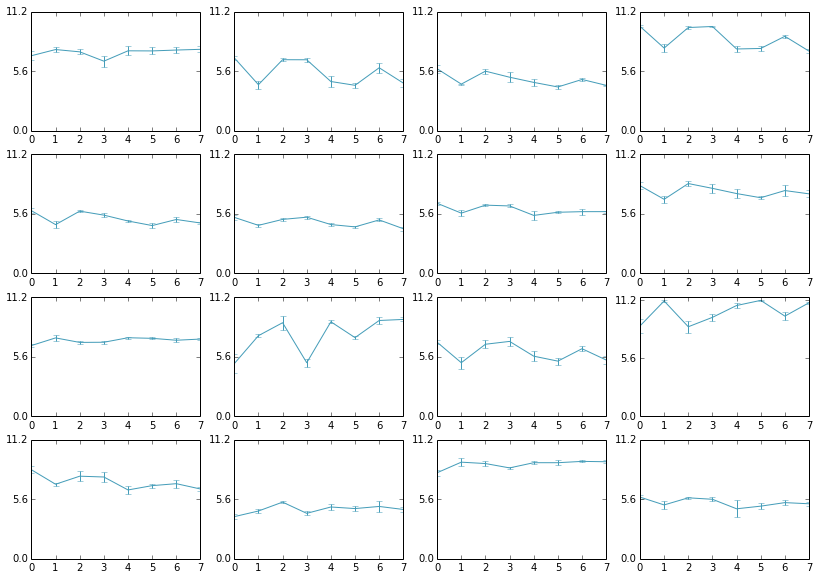

In [4]:
# Looking at the data
num_genes = X.shape[0]

fig = plt.figure()

np.random.seed(42) # look at the same for each repeat

y_min = 20.
y_max = 0.
axes = []
for idx in range(16):
    # Pick a random gene
    gene_idx = np.random.randint(num_genes)
    
    # Get expression values after 4 hours
    mean = []
    stdr = []
    for condition in ordered_conditions:
        condition_key = "%s_4" % condition
        
        mean.append(np.mean(X[gene_idx, samples_columns[condition_key]]))
        stdr.append(np.std(X[gene_idx, samples_columns[condition_key]]))
    
    # Plot
    ax = fig.add_subplot(4, 4, idx)#, sharex=True)
    axes.append(ax)

    ax.errorbar(range(8), mean, yerr=stdr, color='#459db9')
    
    y_max = max(y_max, np.max(mean+stdr))
    y_min = min(y_min, np.min(mean+stdr))
  
y_min = np.round(y_min, 1)
y_max = np.round(y_max, 1)

for ax in axes:
    ax.set_yticks([y_min, (y_min + (y_max-y_min)/2), y_max])
    
fig.subplots_adjust(bottom=0.1, top=2, left=0.2, right=2)


## Identification of profiles in the data by discretization

We compute a discretized representation of each gene, in 8 levels at most, re-ordering LPS, IL10 and TNF in increasing order of corresponding mean log-intensity.

To decide whether two log-intensities are identical or not, we use a moderated t-test such as the one in LIMMA.

### 1. Evaluation of the significant pairwise differences between log-intensities
Using the same moderated t-test as in LIMMA to decide whether two log-intensities are identical or not, we compute the sign (-1, 0 or +1) of all pairwise differences between conditions, for each gene.

**References**
OLS in Python: http://connor-johnson.com/2014/02/18/linear-regression-with-python/
LIMMA: smyth04.pdf + user guide

In [5]:
# Compute the design matrices and corresponding expression matrices
num_genes, num_samples = X.shape

# Re-ordered samples (column index in X)
samples_4hrs = [] 
samples_8hrs = []
for condition in ordered_conditions:
    # Profiles after 4 hours
    condition_key = "%s_4" % condition
    samples_4hrs.extend(samples_columns[condition_key])
    
    # Profiles after 8 hours
    condition_key = "%s_8" % condition
    samples_8hrs.extend(samples_columns[condition_key])

    
# Compute design matrices
design_4hrs = np.zeros((len(samples_4hrs), 8))
design_8hrs = np.zeros((len(samples_8hrs), 8))

row_index_4hrs = 0
row_index_8hrs = 0
for condition_idx, condition in enumerate(ordered_conditions):
    # After 4 hours
    condition_key = "%s_4" % condition
    ns = len(samples_columns[condition_key]) # number of samples with this condition
    design_4hrs[row_index_4hrs:row_index_4hrs + ns, condition_idx] = 1
    row_index_4hrs += ns

    # After 8 hours
    condition_key = "%s_8" % condition
    ns = len(samples_columns[condition_key]) # number of samples with this condition
    design_8hrs[row_index_8hrs:row_index_8hrs + ns, condition_idx] = 1
    row_index_8hrs += ns   

# Re-order log-expression data
expression_4hrs = X[:, samples_4hrs]
expression_8hrs = X[:, samples_8hrs]

In [6]:
# Compute contrast matrix for pairwise comparisons: same for both
contrast = np.zeros((8, 28))
ctst_idx = 0
for cdt_idx_1 in range(8):
    for cdt_idx_2 in range(cdt_idx_1+1, 8):
        contrast[cdt_idx_1, ctst_idx] = -1
        contrast[cdt_idx_2, ctst_idx] = 1
        ctst_idx += 1
#print contrast.shape
#print contrast

In [7]:
import scipy as sp
print sp.__version__

0.13.3


In [100]:
#reload(util_3way)
sigma2_4hrs, mt_test_4hrs, mt_test_comp_4hrs = util_3way.moderated_ttest(design_4hrs, 
                                                                         contrast, expression_4hrs) 
sigma2_8hrs, mt_test_8hrs, mt_test_comp_8hrs = util_3way.moderated_ttest(design_8hrs, 
                                                                         contrast, expression_8hrs) 

Estimated parameters of the F-distribution: (19, 5.5469329162794905, -0.0070223728494859606, 0.11151884691924299)


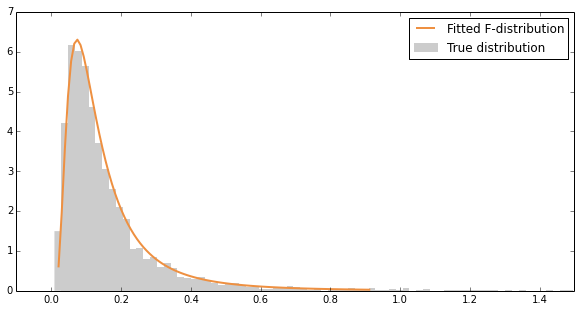

In [91]:
# Validating the F-fitting procedure
plt.figure(figsize=(10, 5))
#print sigma2_4hrs.shape
prms = st.f.fit(sigma2_4hrs, f0=19)#, floc=0)
print "Estimated parameters of the F-distribution:", prms
dfn = prms[0]
dfd = prms[1]
scale_ = prms[3]
loc_ = prms[2]
x = np.linspace(st.f.ppf(0.01, dfn, dfd, scale=scale_, loc=loc_),
                st.f.ppf(0.99, dfn, dfd, scale=scale_, loc=loc_), 100)
    
rv = st.f(dfn, dfd, scale=scale_)#, loc=loc_)
plt.plot(x, rv.pdf(x), color='#ee9041', lw=2, label='Fitted F-distribution')
h = plt.hist(sigma2_4hrs, normed=True, bins=150, color='#cccccc', edgecolor='none', label="True distribution")
xl = plt.xlim(-0.1, 1.5)
leg = plt.legend()

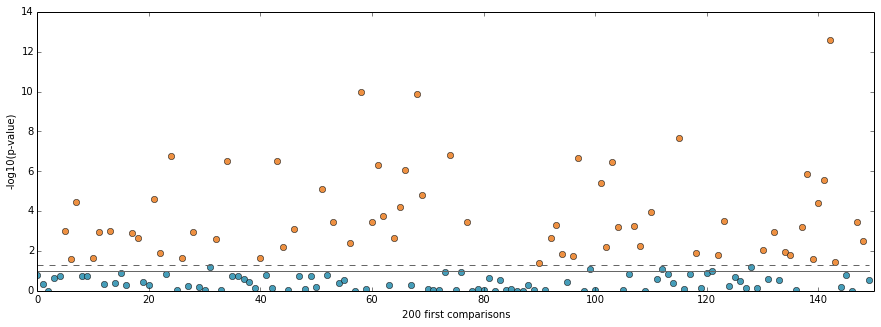

In [118]:
# Playing with p-value thresholds and MHT correction
NUM=150
sample=np.random.choice(np.arange(np.size(mt_test_comp_4hrs)), size=NUM, replace=False)
plt.figure(figsize=(15, 5))
x_sig = np.where(np.abs(mt_test_comp_4hrs.flatten()[sample]) > 0)[0]
x_non = np.where(np.abs(mt_test_comp_4hrs.flatten()[sample]) == 0)[0]
plt.plot(x_sig, 
         -np.log10(mt_test_4hrs.flatten()[sample[x_sig]]), 
         color='#ee9041', marker='o', ls='', label='Currently significant')
plt.plot(x_non, 
         -np.log10(mt_test_4hrs.flatten()[sample[x_non]]), 
         color='#459db9', marker='o', ls='', label='Currently non-significant')

plt.plot(range(NUM), [-np.log10(0.05) for i in sample], color='#666666', ls="--")
#plt.plot(range(NUM), [-np.log10(0.05/np.size(mt_test_4hrs)) for i in range(NUM)], color='#666666')
plt.plot(range(NUM), [-np.log10(0.1) for i in sample], color='#666666')

#l = plt.ylim(-0.1, 15)
l = plt.xlim(0, NUM)
l = plt.ylabel("-log10(p-value)")
l = plt.xlabel("200 first comparisons")

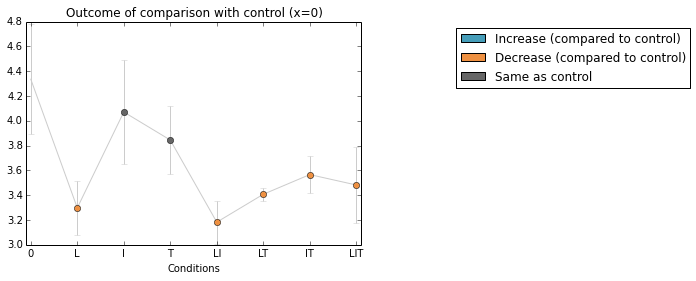

In [117]:
# Checking whether the obtained p-values make sense 

import matplotlib.patches as mpatches

#np.random.seed(42) # look at the same for each repeat

# Pick a random gene
gene_idx = np.random.randint(num_genes)
    
# Get expression values after 4 hours
mean = []
stdr = []
for condition in ordered_conditions:
    condition_key = "%s_4" % condition
       
    mean.append(np.mean(X[gene_idx, samples_columns[condition_key]]))
    stdr.append(np.std(X[gene_idx, samples_columns[condition_key]]))
    
# Plot
plt.errorbar(range(8), mean, yerr=stdr, color='#cccccc')
for i, comparison in enumerate(mt_test_comp_4hrs[gene_idx, :7]):
    if comparison < 0:
        col = '#ee9041'
    elif comparison > 0:
        col = '#459db9'
    else:
        col = '#666666'
    plt.plot([i+1], [mean[i+1]], color=col, marker='o')
plt.xlim([-0.1, 7.1])
plt.title("Outcome of comparison with control (x=0)")
plt.xlabel("Conditions")
plt.xticks(range(8), ['0', 'L', 'I', 'T', 'LI', 'LT', 'IT', 'LIT'])

#orange_patch = mpatches.Patch(color='#459db9', label='Increase (compared to control)')
#blue_patch = mpatches.Patch(color='#ee9041', label='Decrease (compared to control)')
#plt.legend(handles=[orange_patch, blue_patch], bbox_to_anchor=(0, 0))

p1 = mpatches.Rectangle((0, 0), 1, 1, fc="#459db9")
p2 = mpatches.Rectangle((0, 0), 1, 1, fc="#ee9041")
p3 = mpatches.Rectangle((0, 0), 1, 1, fc="#666666")
leg = plt.legend([p1, p2, p3], ["Increase (compared to control)", 
                      "Decrease (compared to control)",
                      "Same as control"], bbox_to_anchor=(1, 0, 1, 1))


### 2. Transform the pairwise differences in log-intensities into delta-profiles
We simplify the log-intensities into *levels*: 
The number L of levels is that significantly different expression values.
Levels are integers between 0 and (L-1). 
The smallest log-intensity is mapped to 0, the second-to-smallest to 1, and so on and so forth.

We also re-order the three conditions LPS, IL10 and TNF in increasing order of corresponding mean log-intensity.
More specifically, we remap them to 'X', 'Y', and 'Z', such that 
  $X \leq Y \leq Z$
  
  if $X = Y$ then $XZ \leq YZ$
  
  if $Y = Z$ then $XY 
  expression(X) <= epression(Y) <= expression(Z)
  if expression(X) == expression(Y) then expression(XZ) <= expression (YZ)
  if expression(Y) == expression(Z) then expression(XY) <= expression (XZ)```

Finally, we substract the level of the first (control) condition to all levels to normalize, and end up with a *delta-profile* of size 7.

In [129]:
# Compute delta-profiles based on (reordered) levels, compared to control
reload(util_3way)
delta_profiles_4hrs = util_3way.compute_delta_profiles(mt_test_comp_4hrs)
delta_profiles_8hrs = util_3way.compute_delta_profiles(mt_test_comp_8hrs)
delta_profiles = np.vstack((delta_profiles_4hrs, delta_profiles_8hrs))
#print delta_profiles.shape
#print delta_profiles[0, :]

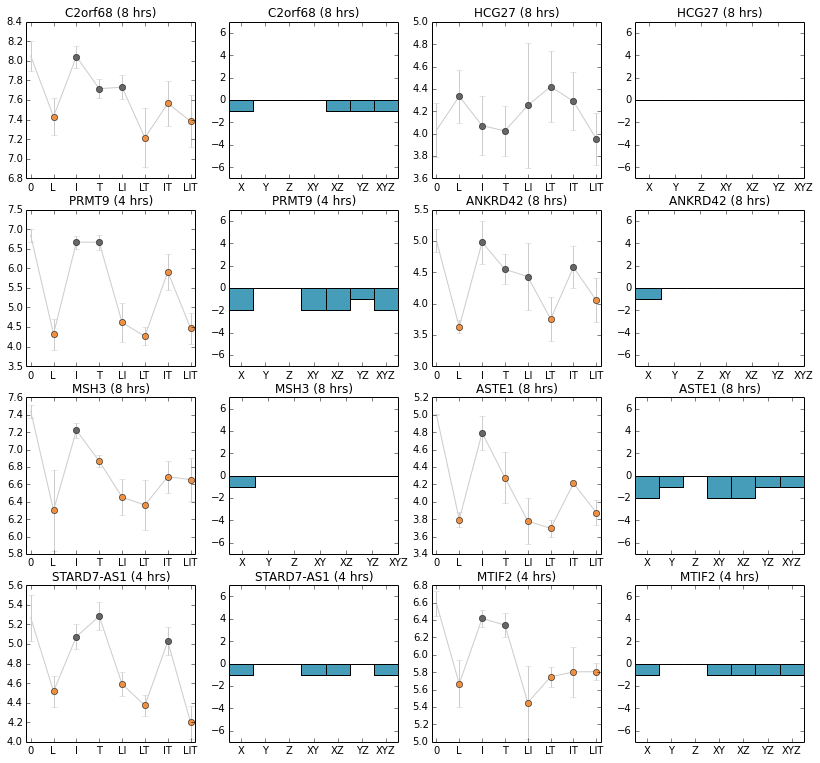

In [132]:
# Looking at some delta_profiles
fig = plt.figure()

np.random.seed(42) # look at the same for each repeat


for idx in range(1, 17, 2):
    # Pick a random gene and time
    profile_idx = np.random.randint(num_genes*2)
    if profile_idx > num_genes:
        timepoint = 8
        gene_idx = profile_idx - num_genes
        mt_test_comp = mt_test_comp_8hrs
    else:
        timepoint = 4
        gene_idx = profile_idx
        mt_test_comp = mt_test_comp_4hrs
    
    # Plot data
    ax = fig.add_subplot(4, 4, idx)
    #axes.append(ax)
    
    mean = []
    stdr = []
    for condition in ordered_conditions:
        condition_key = "%s_%d" % (condition, timepoint)
        
        mean.append(np.mean(X[gene_idx, samples_columns[condition_key]]))
        stdr.append(np.std(X[gene_idx, samples_columns[condition_key]]))
    
    ax.errorbar(range(8), mean, yerr=stdr, color='#cccccc')
    for i, comparison in enumerate(mt_test_comp[gene_idx, :7]):
        if comparison < 0:
            col = '#ee9041'
        elif comparison > 0:
            col = '#459db9'
        else:
            col = '#666666'
        ax.plot([i+1], [mean[i+1]], color=col, marker='o')
    ax.set_xlim([-0.2, 7.2])
    xtickNames = ax.set_xticklabels(['0', '0', 'L', 'I', 'T', 'LI', 'LT', 'IT', 'LIT'])
    ax.set_title("%s (%d hrs)" % (gene_names[gene_idx], timepoint))


    # Plot profile
    ax = fig.add_subplot(4, 4, idx+1)
    
    bar_hght = delta_profiles[profile_idx, :]
    bar_hght_pos = [value if value > 0 else 0 for value in bar_hght]
    bar_hght_neg = [value if value < 0 else 0 for value in bar_hght]
    
    left_pos = range(7)    
    ax.set_ylim(-7, 7)
    
    ax.bar(left_pos, bar_hght_pos, width=1, color='#459db9')
    ax.bar(left_pos, bar_hght_neg, width=1, color='#459db9')
    
    ax.set_xticks([x+0.5 for x in left_pos])
    xtickNames = ax.set_xticklabels(['X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'XYZ'])
    ax.set_title("%s (%d hrs)" % (gene_names[gene_idx], timepoint))
    
fig.subplots_adjust(bottom=0, top=2.5, left=0.2, right=2)

344 different profiles out of 7846 genes x timepoints


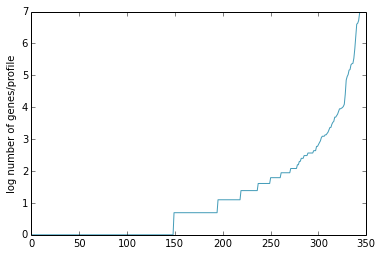

In [133]:
# Check out how many different delta-profiles there is in the data
# Construct a dictionary of delta-profiles
profiles_dict = {} # string representation of delta-profile:[list of gene_idx with that profile]
for profile_idx in range(num_genes*2):
    profile_str = "_".join(["%d" % x for x in delta_profiles[profile_idx, :]])
    if profiles_dict.has_key(profile_str):
        profiles_dict[profile_str].append(profile_idx)
    else:
        profiles_dict[profile_str] = [profile_idx]

print "%d different profiles out of %d genes x timepoints" % (len(profiles_dict.keys()), (num_genes*2))

# Number of genes with each profile
num_genes_per_profile = [len(val) for key, val in profiles_dict.iteritems()]
num_genes_per_profile.sort()
#print "Number of genes per profile:", num_genes_per_profile
#print range(len(num_genes_per_profile))
plt.plot(range(len(num_genes_per_profile)), np.log(num_genes_per_profile), color='#459db9')
yl = plt.ylabel('log number of genes/profile')

At most 1045 genes with the same profile.


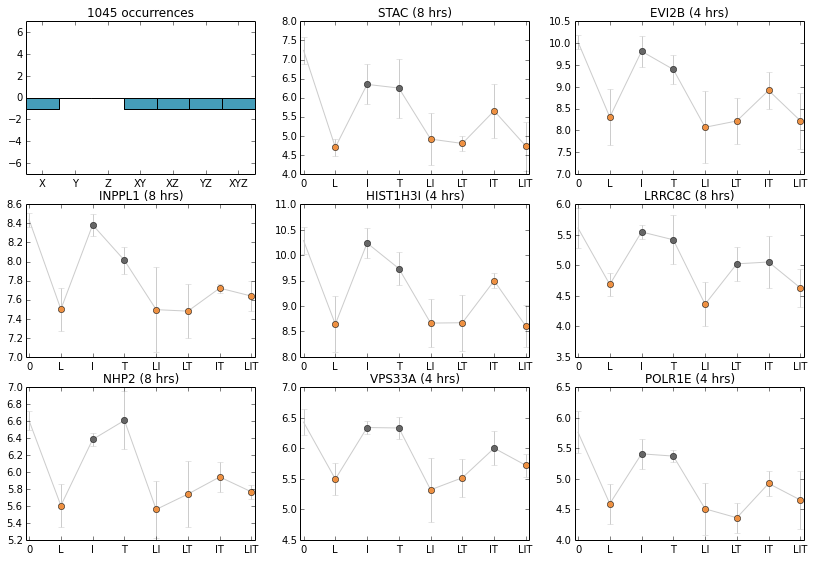

In [134]:
# Most popular profile
max_num_genes_per_profile = max(num_genes_per_profile)
print "At most", max_num_genes_per_profile, "genes with the same profile."
fig = plt.figure()
idx = 0
for key, val in profiles_dict.iteritems():
    if len(val) == max_num_genes_per_profile:
        #print key, len(val)
        #for v in val[:10]:
        #    print v, delta_profiles[v, :]
        # plot delta-profile
        idx += 1
        ax = fig.add_subplot(3, 3, idx)
        
        profile_idx = val[0]
        
        bar_hght = delta_profiles[profile_idx, :]
        bar_hght_pos = [value if value > 0 else 0 for value in bar_hght]
        bar_hght_neg = [value if value < 0 else 0 for value in bar_hght]
    
        left_pos = range(7)    
        ax.set_ylim(-7, 7)
    
        ax.bar(left_pos, bar_hght_pos, width=1, color='#459db9')
        ax.bar(left_pos, bar_hght_neg, width=1, color='#459db9')
    
        ax.set_xticks([x+0.5 for x in left_pos])
        xtickNames = ax.set_xticklabels(['X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'XYZ'])
        ax.set_title("%d occurrences" % len(val))
        
        # indices of profiles with that delta profile
        prof_indices = [val[i] for i in (np.random.choice(range(len(val)-1), size=(8, ), replace=False) + 1)]
        
        for prof_idx in prof_indices:
            idx += 1
            ax = fig.add_subplot(3, 3, idx)
            
            if prof_idx > num_genes:
                timepoint = 8
                gene_idx = prof_idx - num_genes
                mt_test_comp = mt_test_comp_8hrs
            else:
                timepoint = 4
                gene_idx = prof_idx
                mt_test_comp = mt_test_comp_4hrs

            mean = []
            stdr = []
            for condition in ordered_conditions:
                condition_key = "%s_%d" % (condition, timepoint)

                mean.append(np.mean(X[gene_idx, samples_columns[condition_key]]))
                stdr.append(np.std(X[gene_idx, samples_columns[condition_key]]))

            ax.errorbar(range(8), mean, yerr=stdr, color='#cccccc')
            for i, comparison in enumerate(mt_test_comp[gene_idx, :7]):
                if comparison < 0:
                    col = '#ee9041'
                elif comparison > 0:
                    col = '#459db9'
                else:
                    col = '#666666'
                ax.plot([i+1], [mean[i+1]], color=col, marker='o')
            ax.set_xlim([-0.1, 7.1])
            xtickNames = ax.set_xticklabels(['0', '0', 'L', 'I', 'T', 'LI', 'LT', 'IT', 'LIT'])
            ax.set_title("%s (%d hrs)" % (gene_names[gene_idx], timepoint))
        
fig.subplots_adjust(bottom=0, top=1.8, left=0.2, right=2)
    
fig.savefig(('profile_%d_examples.pdf' % max_num_genes_per_profile), bbox_inches='tight')    

In [135]:
print num_genes_per_profile[-10:]

[207, 214, 216, 254, 343, 503, 740, 761, 829, 1045]


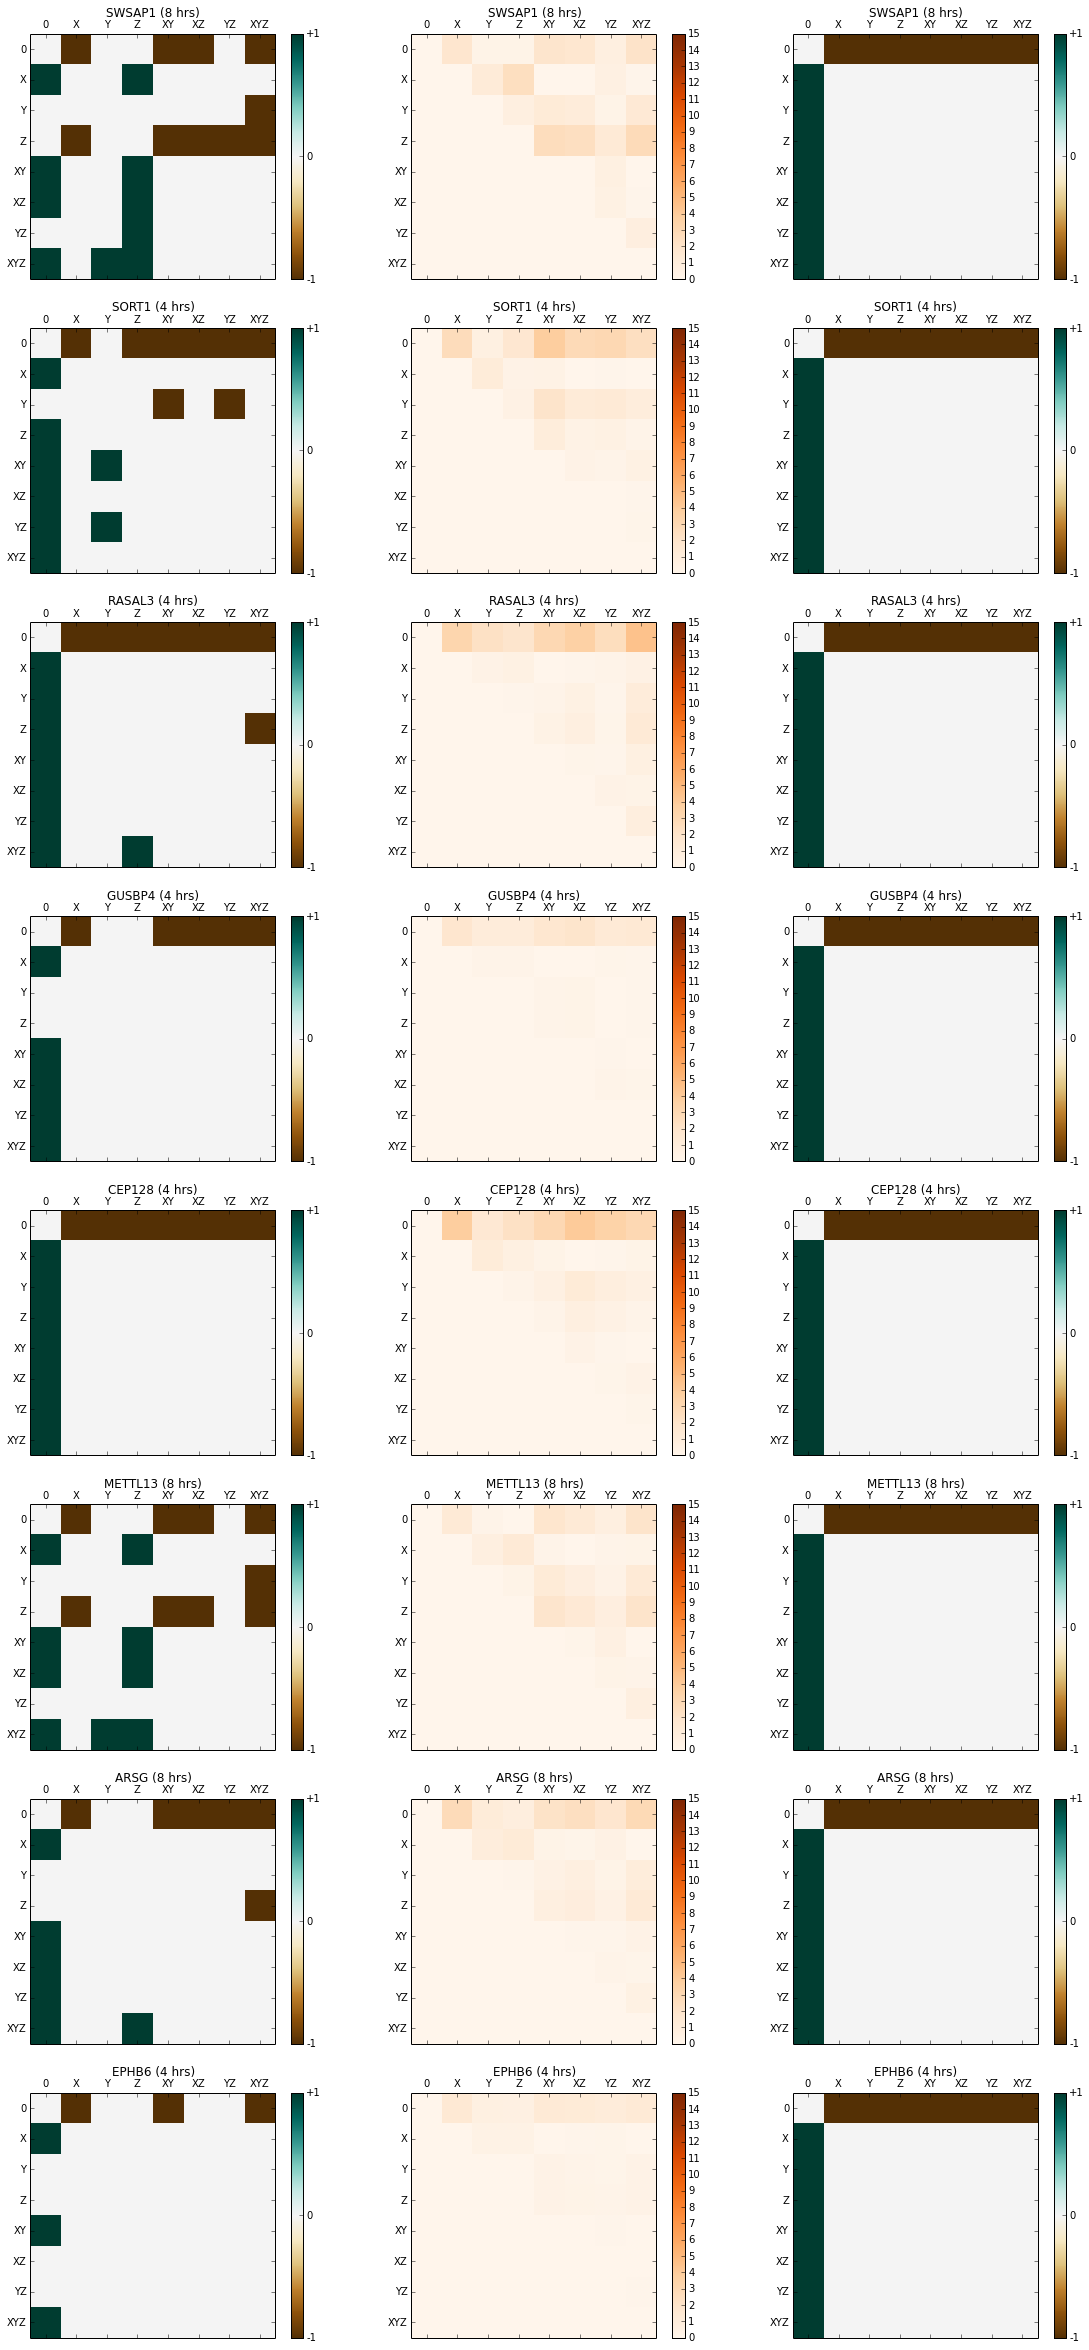

In [136]:
# Issue of transitivity when transforming mt_test_comp into comp_array
reload(util_3way)
import matplotlib.colorbar as mplcolbar
fig = plt.figure()
idx = 0
for key, val in profiles_dict.iteritems():
    if len(val) == num_genes_per_profile[-4]: #max_num_genes_per_profile:
        profile_idx = val[0]

        # indices of profiles with that delta profile
        prof_indices = [val[i] for i in (np.random.choice(range(len(val)-1), size=(8, ), replace=False) + 1)]
        
        for prof_idx in prof_indices:
            idx += 1
            ax = fig.add_subplot(8, 3, idx)
            
            if prof_idx > num_genes:
                timepoint = 8
                gene_idx = prof_idx - num_genes
                mt_test_comp = mt_test_comp_8hrs
                mt_test = mt_test_8hrs
            else:
                timepoint = 4
                gene_idx = prof_idx
                mt_test_comp = mt_test_comp_4hrs
                mt_test = mt_test_4hrs
                
            # Original comp_array
            comp_array = util_3way.compute_comp_array(mt_test_comp[gene_idx, :])
            
            xyz_map = util_3way.compute_XYZ_map(comp_array)
            comp_array_reordered = comp_array[xyz_map, :]
            comp_array_reordered = comp_array_reordered[:, xyz_map]                  
            #comp_array_reordered[np.tril_indices(comp_array_reordered.shape[0])] = 0
            
            cax = ax.matshow(comp_array_reordered, cmap=plt.cm.BrBG, vmin=-1, vmax=1)
            
            ax.set_xticklabels(['0', '0', 'X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'XYZ'])
            ax.set_yticklabels(['0', '0', 'X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'XYZ'])

            cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
            cbar.ax.set_yticklabels(['-1', '0', '+1'])  # vertically oriented colorbar            
            ax.set_title("%s (%d hrs)" % (gene_names[gene_idx], timepoint))
            
            # Comp_array with p-values
            idx += 1
            ax = fig.add_subplot(8, 3, idx)
            
            comp_array2 = util_3way.compute_comp_array_pval(mt_test[gene_idx, :])
            
            comp_array_reordered2 = comp_array2[xyz_map, :]
            comp_array_reordered2 = comp_array_reordered2[:, xyz_map]      
            #comp_array_reordered2[np.tril_indices(comp_array_reordered2.shape[0])] = 0
            
            cax = ax.matshow(comp_array_reordered2, cmap=plt.cm.Oranges, vmin=0, vmax=15)
            
            ax.set_xticklabels(['0', '0', 'X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'XYZ'])
            ax.set_yticklabels(['0', '0', 'X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'XYZ'])

            cbar = fig.colorbar(cax, ticks=range(16))
            cbar.ax.set_yticklabels(['%d' % x for x in range(16)])  # vertically oriented colorbar            
            ax.set_title("%s (%d hrs)" % (gene_names[gene_idx], timepoint))
            
            # Transitive comp_array
            idx += 1
            ax = fig.add_subplot(8, 3, idx)
                
            t_comp_array = util_3way.make_transitive(comp_array_reordered)
            #t_comp_array[np.tril_indices(t_comp_array.shape[0])] = 0
            
            cax = ax.matshow(t_comp_array, cmap=plt.cm.BrBG, vmin=-1, vmax=1)
            
            ax.set_xticklabels(['0', '0', 'X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'XYZ'])
            ax.set_yticklabels(['0', '0', 'X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'XYZ'])

            cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
            cbar.ax.set_yticklabels(['-1', '0', '+1'])  # vertically oriented colorbar            
            ax.set_title("%s (%d hrs)" % (gene_names[gene_idx], timepoint))
            
            
        
fig.subplots_adjust(bottom=0, top=8, left=0, right=2.5)
 

22 profiles appear more than 50 times.


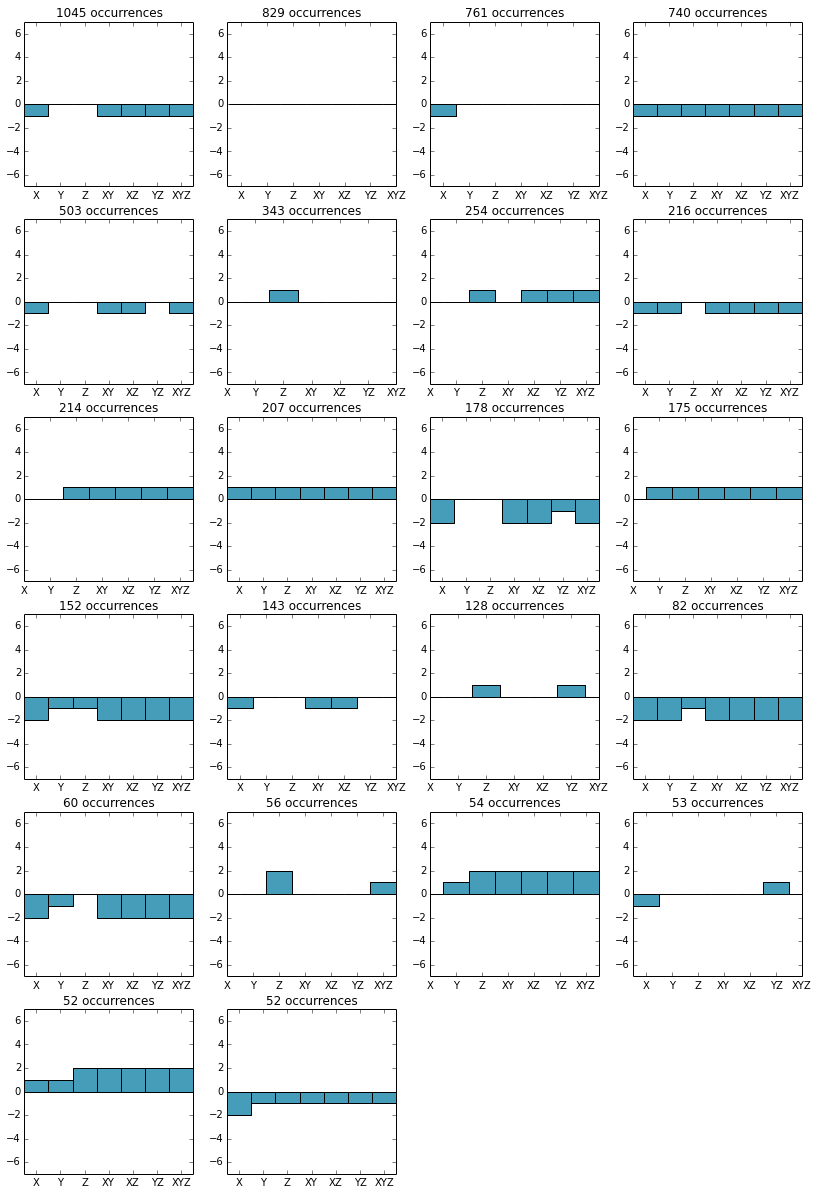

In [137]:
# Plot most popular profiles
print len(np.where(np.array(num_genes_per_profile) >= 50)[0]), "profiles appear more than 50 times."

# Sort delta-profiles per number of genes that match
dd = {} # len(val): key
for key, val in profiles_dict.iteritems():
    ll = len(val)
    if not dd.has_key(ll):
        dd[ll] = [key]
    else:
        dd[ll].append(key)
dd_keys = dd.keys()
dd_keys.sort()
dd_keys.reverse()
sorted_profiles_dict_keys = []
for ll in dd_keys:
    sorted_profiles_dict_keys.extend(dd[ll])


fig = plt.figure()

idx = 0
for key in sorted_profiles_dict_keys:
    val = profiles_dict[key]
    if len(val) < 50:
        break
    idx += 1
    ax = fig.add_subplot(6, 4, idx)

    profile_idx = val[0]

    bar_hght = delta_profiles[profile_idx, :]
    bar_hght_pos = [value if value > 0 else 0 for value in bar_hght]
    bar_hght_neg = [value if value < 0 else 0 for value in bar_hght]

    left_pos = range(7)    
    ax.set_ylim(-7, 7)

    ax.bar(left_pos, bar_hght_pos, width=1, color='#459db9')
    ax.bar(left_pos, bar_hght_neg, width=1, color='#459db9')

    ax.set_xticks([x+0.5 for x in left_pos])
    xtickNames = ax.set_xticklabels(['X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'XYZ'])
    ax.set_title("%d occurrences" % len(val))
        
fig.subplots_adjust(bottom=0, top=4, left=0.2, right=2)
fig.savefig('top_profiles.pdf', bbox_inches='tight')

351 profiles appear only once.


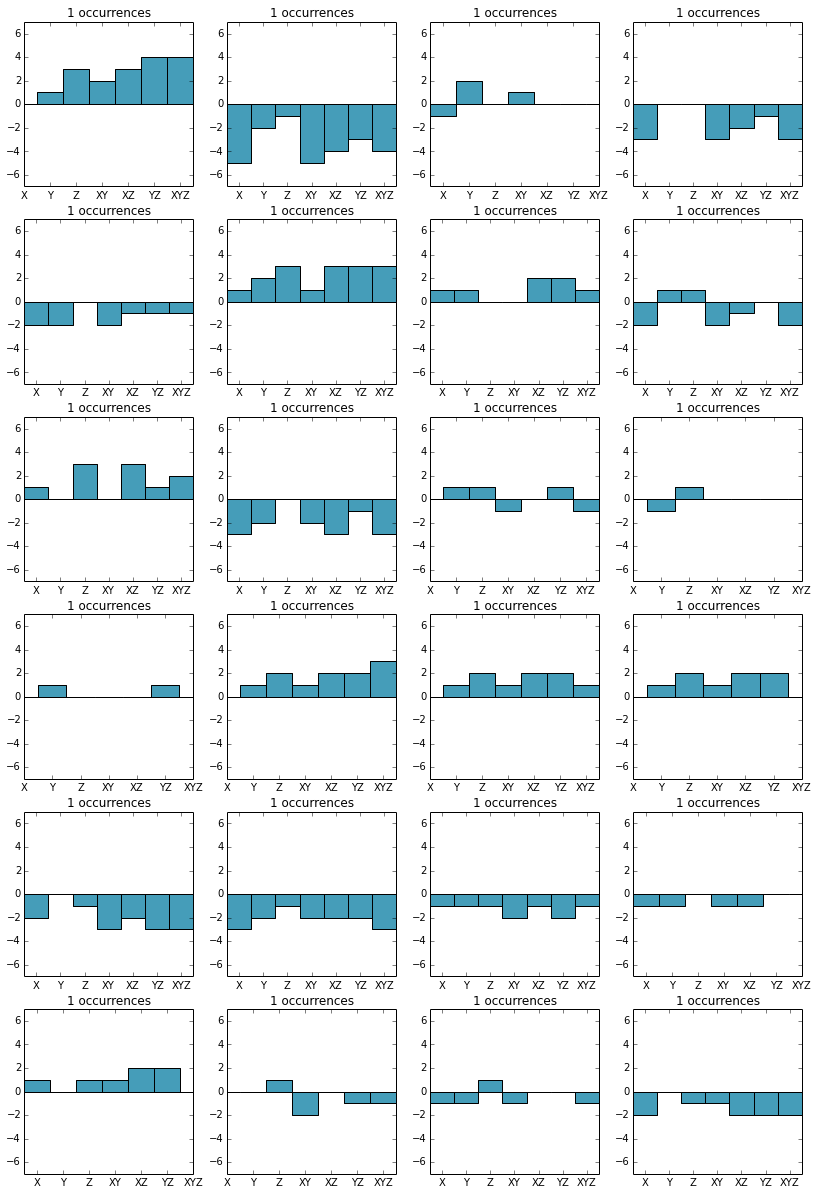

In [17]:
# Plot some of the least popular profiles
print len(np.where(np.array(num_genes_per_profile) == 1)[0]), "profiles appear only once."

# Sort delta-profiles per number of genes that match
dd = {} # len(val): key
for key, val in profiles_dict.iteritems():
    ll = len(val)
    if not dd.has_key(ll):
        dd[ll] = [key]
    else:
        dd[ll].append(key)
dd_keys = dd.keys()
dd_keys.sort()
#dd_keys.reverse()
sorted_profiles_dict_keys = []
for ll in dd_keys:
    sorted_profiles_dict_keys.extend(dd[ll])


fig = plt.figure()

idx = 0
for key in sorted_profiles_dict_keys:
    val = profiles_dict[key]
    if idx > 23:
        break
    idx += 1
    ax = fig.add_subplot(6, 4, idx)

    profile_idx = val[0]

    bar_hght = delta_profiles[profile_idx, :]
    bar_hght_pos = [value if value > 0 else 0 for value in bar_hght]
    bar_hght_neg = [value if value < 0 else 0 for value in bar_hght]

    left_pos = range(7)    
    ax.set_ylim(-7, 7)

    ax.bar(left_pos, bar_hght_pos, width=1, color='#459db9')
    ax.bar(left_pos, bar_hght_neg, width=1, color='#459db9')

    ax.set_xticks([x+0.5 for x in left_pos])
    xtickNames = ax.set_xticklabels(['X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'XYZ'])
    ax.set_title("%d occurrences" % len(val))
        
fig.subplots_adjust(bottom=0, top=4, left=0.2, right=2)
#fig.savefig('bottom_profiles.pdf', bbox_inches='tight')

**Notes** 
* I have 733 genes/timepoints with no departure from control, so this look like a more stringent test than was used to process the data.
* One issue is the *transitivity* of this approach: It can be that X is not significantly different from Y and Y not significantly different from Z but that X and Z differ significantly.
* When is such a profile *not* a 3-way interaction?

### 3. Total number of possible delta-profiles.

We want to count the number of vectors $X$ of $\{0, 1, ..., 7\}^8$ such that:

1) All the values used are consecutive, i.e. all values between $0$ and $\max(X)$ must appear.
For example, [1, 3, 3, 3, 3, 3, 3, 4] is not valid.

2) $X_1 \leq X_2 \leq X3$

3) If $X_1 = X_2$ and $X_2 \neq X_3$ then $X_5 < X_6$

4) If $X_2 = X_3$ and $X_3 \neq X_4$ then $X_4 < X_5$

5) If $X_1 = X_2 = X_3$ then $X_4 \leq X_5 \leq X_6$

Let us call $A_n$ the number of vectors that verify (1) and such that $\max(X) = n$. The number of possible profiles is $\sum_{n=1}^8 A_n$.

Let us call $B_n$ the number of vectors such that $\max(X) \leq n$ that verify (2)-(5).

You can map any element of $\mathcal{B}_n$ to an element of $\mathcal{A}_k$ (by mapping its elements to smaller values so that (1) is verified). There are ${n \choose k}$ ways of mapping an element of $\mathcal{A}_k$ to an element of  $\mathcal{B}_n$ taking $k$ different values.

Hence $B_n = \sum_{k=1}^n A_k {n \choose k}$.

$B_1 = A_1 {1 \choose 1}$ hence $A_1 = B_1 = 1$.

$B_2 = A_1 {2 \choose 1} + A_2 {2 \choose 2}$ hence $A_2 = B_2 - A_1 {2 \choose 1}$

etc.

and $B_n$ can be computed as
$B_n = n^2  \left ( n^3 {n \choose 3} + 2n {n \choose 2}^2 + n {n+2 \choose 3} \right )$. Indeed:

* $n^2$ corresponds to $X_0$ and $X_7$, which can have any value.
* $n^3 {n \choose 3}$ corresponds to $X_1 < X_2 < X_3$, in which case $X_4, X_5, X_6$ can take any value: ${n \choose 3}$ possibilities for $X_1, X_2, X_3$ and $n^3$ for $X_4, X_5, X_6$. 
* $2 n {n \choose 2}^2$ corresponds to $X_1 < X_2 = X_3$ ( ${n \choose 2}$ possibilities for $X_1, X_2$), in which case $X_4 < X_5$ (${n \choose 2}$ possibilities for $X_4, X_5$), and $X_6$ can take any value, or, equivalently, to $X_1 = X_2 < X_3$, in which case $X_5 < X_6$.
* $n {n+2 \choose 3}$ corresponds to $X_1 = X_2 = X_3$ ($n$ possibilities), in which case $X4 \leq X5 \leq X6$ (${n+2 \choose 3}$ possibilities, draw 3 values among n with replacement).

In [ ]:
B = []
for n in range(8):
    b = (n+1)**3 * ((n+1)**2 * sp.comb((n+1), 3, exact=True) + \
                   2 * sp.comb((n+1), 2, exact=True)**2 + \
                   sp.comb((n+3), 3, exact=True))
    B.append(b)
#print B

A = []
for n in range(8):
    # An = Bn - \sum_{k=1}^{n-1} Ak sp.comb(n, k, exact=True)
    #print "An = ", B[n], 
    sum_a = 0
    for k in range(n):
        #print "-", A[k], "*", sp.comb((n+1), (k+1), exact=True),
        sum_a += A[k] * sp.comb((n+1), (k+1), exact=True)
    An = B[n] - sum_a
    #print "=", An
    A.append(An)
#print A
print np.sum(A), "possible profiles."

## Clustering
Take average of gene expression, re-order LPS, IL10, TNF-a into $X \leq Y \leq Z$

In [ ]:
# Computing average profiles
profiles = np.zeros((num_genes*2, 8))

for condition_idx in range(8):
    condition = "{0:03b}".format(condition_idx) # transforms 3 in 011
    # Profiles after 4 hours
    condition_key = "%s_4" % condition
    profiles[:num_genes, condition_idx] = np.mean( X[:, samples_columns[condition_key]], axis=1)
    
    # Profiles after 8 hours
    condition_key = "%s_8" % condition
    profiles[num_genes:, condition_idx] = np.mean( X[:, samples_columns[condition_key]], axis=1)

In [ ]:
comp_array = np.zeros((8, 8), dtype='int') 
profiles_reordered = np.array(profiles)
for gene_idx in range(profiles.shape[0]):
#for gene_idx in [860]:
    #print "profile", profiles[gene_idx, :]
    for condition1 in range(8):
        for condition2 in range(condition1+1, 8):
            if profiles[gene_idx, condition1] < profiles[gene_idx, condition2]:
                comp_array[condition1, condition2] = 1
                comp_array[condition2, condition1] = -1
            elif  profiles[gene_idx, condition1] > profiles[gene_idx, condition2]:
                comp_array[condition1, condition2] = -1
                comp_array[condition2, condition1] = 1
            #print condition1, condition2, profiles[gene_idx, condition1],  profiles[gene_idx, condition2],
            #print comp_array[condition1, condition2]
    #print "comp_array"
    #print comp_array
    xyz_map = compute_XYZ_map(comp_array)
    #print "xyz_map", xyz_map
    profiles_reordered[gene_idx, :] = profiles[gene_idx, xyz_map]
    #print "profiles_reordered", profiles_reordered[gene_idx, :]
    #break

In [ ]:
# Plot reordered profiles
fig = plt.figure()

np.random.seed(42) # look at the same for each repeat


for idx in range(1, 17, 2):
    # Pick a random gene
    gene_idx = np.random.randint(num_genes)
    
    # Plot profile
    ax = fig.add_subplot(4, 4, idx)
    #axes.append(ax)
    
    mean = []
    stdr = []
    for condition_idx in range(8):
        condition = "{0:03b}".format(condition_idx) # transforms 3 in 011
        condition_key = "%s_4" % condition
        
        mean.append(np.mean(X[gene_idx, samples_columns[condition_key]]))
        stdr.append(np.std(X[gene_idx, samples_columns[condition_key]]))
    
    ax.errorbar(range(8), mean, yerr=stdr, color='#cccccc')
    for i, comparison in enumerate(mt_test_comp[gene_idx, :7]):
        if comparison < 0:
            col = '#ee9041'
        elif comparison > 0:
            col = '#459db9'
        else:
            col = '#666666'
        ax.plot([i+1], [mean[i+1]], color=col, marker='o')
    ax.set_xlim([-0.1, 7.1])
    ax.set_xticklabels(['0', 'L', 'I', 'T', 'LI', 'LT', 'IT', 'LIT'])
    ax.set_title("Gene: %d" % gene_idx)

    # Plot reordered profile
    ax = fig.add_subplot(4, 4, idx+1)    
    
    ax.plot(range(8), profiles_reordered[gene_idx, :], color='#666666')
    
    ax.set_xlim([-0.1, 7.1])
    ax.set_xticklabels(['0', 'X', 'Y', 'Z', 'XY', 'XZ', 'YX', 'XYZ'])
    ax.set_title("Gene: %d" % gene_idx)
    
fig.subplots_adjust(bottom=0, top=2.5, left=0.2, right=2)

In [ ]:
# Try DBSCAN
clustr = cluster.DBSCAN(eps=0.01, min_samples=5, # min number of samples per cluster
                        metric='correlation',
                        algorithm='brute') # only possibility for 'correlation' metric
clustr.fit(profiles_reordered)
labels = clustr.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # -1 is label for noise

print('Estimated number of clusters: %d' % n_clusters_)
print('Number of outliers: %d' % len(np.where(labels==-1)[0]))
print("Silhouette Coefficient: %0.3f" % \
      metrics.silhouette_score(profiles, labels, metric='correlation'))

# TESTS

### Test: LIMMA with rpy2

To install rpy2:
   ```
   sudo pip install rpy2
   ```

Had a few missing libraries:
```
 sudo -E aptitude install libreadline-dev   
 sudo aptitude install liblzma-dev  
 sudo aptitude install libbz2-dev   
```


To install limma in R:
  ```
  R
  > source("https://bioconductor.org/biocLite.R")
  > biocLite("limma")```

In [ ]:
# Tests
comparisons = mt_test_comp[71, :]
print "comparisons",comparisons
comp_array = compute_comp_array(comparisons)
print "comp_array"
print comp_array
levels = np.array(compute_levels(comp_array))
print "levels", levels
xyz_map = compute_XYZ_map(comp_array)
print "xyz_map", xyz_map
levels_reordered = levels[xyz_map]
print "levels_reordered", levels_reordered
print (levels_reordered-levels_reordered[0])[1:]

## Clustering
I have no a-priori idea (at this stage) of the number of clusters.

Choice of distance: 
* The absolute values must not matter
* What matters is whether there is increase/decrease/no change from one level to the other
We will use the correlation distance.

Choice of algorithm:
* We have no idea about the number of clusters
* Clusters might have very different sizes

Hierarchical clustering might be useful in this context, but we'll start by DBSCAN and see if it gives us anything.


In [ ]:
clustr = cluster.DBSCAN(eps=0.01, min_samples=5, # min number of samples per cluster
                    metric='correlation',
                    algorithm='brute') # only possibility for 'correlation' metric
clustr.fit(profiles)
labels = clustr.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # -1 is label for noise

print('Estimated number of clusters: %d' % n_clusters_)
print('Number of outliers: %d' % len(np.where(labels==-1)[0]))

In [ ]:
print("Silhouette Coefficient: %0.3f" % \
      metrics.silhouette_score(profiles, labels, metric='correlation'))

DBSCAN results are not satisfactory: either 1 cluster or a few clusters and most samples are outliers.
We'll try hierarchical clustering instead.

In [ ]:
n_clusters_ = 20
clustr = cluster.AgglomerativeClustering(n_clusters=n_clusters_)

clustr.fit(profiles)
labels = clustr.labels_

#Number of samples per clusters:
print [len(np.where(labels==clustr_idx)[0]) for clustr_idx in range(n_clusters_)]

In [ ]:
print("Silhouette Coefficient: %0.3f" % \
      metrics.silhouette_score(profiles, labels, metric='correlation'))

Results: 
   ```[494, 447, 317, 725, 120, 154, 552, 275, 875, 736, 349, 611, 553, 244, 312, 242, 89, 243, 47, 461]
   Silhouette coefficient = -0.313.```

This is quite time-consuming, I don't get the hierarchy, and we'd need to test a large number of cluster numbers to decide which one is best (and whether anything is good).

* Probably should re-order LPS, IL10 and TNF in increasing value for each profile.
* Maybe dynamical time-warping for clustering?

In [ ]:
y = range(7)
print y
print [x if x > 0 else 0.1 for x in y]

In [ ]:
# Variance of all values for each condition, timepoint, gene
fig = plt.figure()
idx = 0
for key, col_indices in samples_columns.iteritems():
    idx += 1
    ax = fig.add_subplot(4, 4, idx)
    Xthis = X[:, col_indices]
    var = np.std(Xthis, axis=1)
    ax.hist(var, color='#459db9')
    ax.set_title(key)
    ax.set_yticks([0, 1000, 2000])
    ax.set_xticks([0.0, 1.0, 2.0, 3.0])
fig.subplots_adjust(bottom=0.1, top=2, left=0.2, right=2)

In [ ]:
# Some tests, not needed any more
print "mt_test:", mt_test.shape
# Transform significance into +/-/=
print "Expression:", expression_4hrs.shape
print "Contrast:", contrast.shape
print "Design: ", design_4hrs.shape
comp_idx = 0
gene_idx = 0

mt_test_comp = np.zeros(mt_test.shape)

#print np.where(mt_test[gene_idx, :] < 0.05)[0]
for gene_idx in range(mt_test_comp.shape[0]):
    for comp_idx in np.where(mt_test[gene_idx, :] < 0.05)[0]:
        #print contrast[:, condition_idx]
        #print np.where(design_4hrs[:, (np.where(contrast[:, condition_idx] == -1))[0]])
        b = np.mean(expression_4hrs[gene_idx, np.where(design_4hrs[:, list(contrast[:, comp_idx]).index(-1)])[0]])
        a = np.mean(expression_4hrs[gene_idx, np.where(design_4hrs[:, list(contrast[:, comp_idx]).index(1)])[0]])
        #print b-a, 
        mt_test_comp[gene_idx, comp_idx] = np.sign(a - b)

print mt_test_comp[10, :]

In [ ]:
print 'a'

In [ ]:
# Some tests, not needed any more
print mt_test_comp[0, :]
comp_array = compute_comp_array(mt_test_comp[0, :])
print "Comp array:\n", comp_array
print "Levels:", compute_levels(comp_array)
print "XYZ_map:", compute_XYZ_map(comp_array)
#a = [x for i, x in enumerate(mt_test_comp[0, :]) if (i < 12) else (-x)]
a = []
for i, x in enumerate(mt_test_comp[0, :]):
    if i < 12:
        a.append(x)
    else:
        a.append(-x)
print a
comp_array = compute_comp_array(a)
print "Comp array:\n", comp_array
print "Levels:", compute_levels(comp_array)
print "XYZ_map:", compute_XYZ_map(comp_array)

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
limma = importr('limma')